# Load the model from file

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from pathlib import Path
from os.path import abspath

ROOT_DIR = Path(abspath('')).parent.parent
MODEL_PATH = ROOT_DIR / "raw" / "checkpoints" / "lstm7_best1"


model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Metal device set to: Apple M1 Max


2022-12-12 19:25:37.465791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 19:25:37.465929: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-12 19:25:42.018554: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 19:25:42.018727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:42.112996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 75)           7500000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 2056)        9079296   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              2237440   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                        

# Load the "outer" dataset

In [2]:
OUTER_DS_DIR = ROOT_DIR / "raw" / "outer_dataset"
DATASET_DIR = ROOT_DIR / "raw" / "dataset"
BATCH_SIZE = 256
SEED = 7312

outer_ds = tf.keras.utils.text_dataset_from_directory(
    directory=OUTER_DS_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)
outer_ds.class_names

Found 787 files belonging to 2 classes.


['entertainment', 'tech']

# Predicting on outer dataset

In [3]:
result = model.predict(outer_ds)

2022-12-12 19:25:42.831084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:42.953909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:42.964632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:44.213828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:44.238498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 5s 770ms/step


In [4]:
import pandas as pd
import numpy as np

original_dataset_labels = ['business', 'politics', 'sport']
original_ds = train_ds = tf.keras.utils.text_dataset_from_directory(
    directory=DATASET_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

outer_dataset_labels = outer_ds.class_names
actual_outer_labels = np.concatenate([[outer_dataset_labels[0] if y[0] else outer_dataset_labels[1] for y in y_batch] for x_batch, y_batch in outer_ds], axis=0)
result_df = pd.DataFrame(result, columns=original_dataset_labels)
result_df["Outer label"] = actual_outer_labels
# result_df

predict_original = model.predict(original_ds)

Found 1438 files belonging to 3 classes.


2022-12-12 19:25:49.171852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:49.294758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:49.306223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:50.325124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:50.340805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 5s 671ms/step


In [5]:
model.evaluate(original_ds)

2022-12-12 19:25:54.699437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:54.844447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:54.858681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:55.855764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:25:55.870699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 6s 694ms/step - loss: 0.1243 - accuracy: 0.9722 - recall: 0.9722 - precision: 0.9729 - auc: 0.9927


[0.12428556382656097,
 0.9721835851669312,
 0.9721835851669312,
 0.9728601574897766,
 0.9926711320877075]

In [6]:
def get_max_softmax(softmax: np.ndarray) -> float:
    return np.max(softmax)
    # return original_dataset_labels[np.argmax(softmax)]

histogram_data = np.apply_along_axis(get_max_softmax, 1, result)
original_hist_data = np.apply_along_axis(get_max_softmax, 1, predict_original)

# Plot the histogram

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1., 

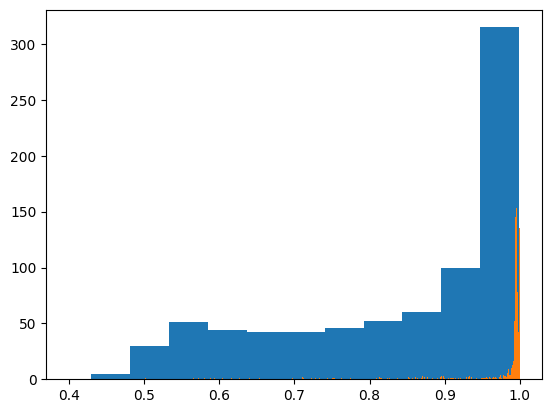

In [10]:
import matplotlib.pyplot as plt

plt.hist(histogram_data, bins='auto')
plt.hist(original_hist_data, bins='auto')
# plt.xlim(0.95, 1)